In [1]:
import numpy as np
import pymc as pm
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.data import Datasets
from pyei.plot_utils import tomography_plot
from pyei.io_utils import from_netcdf, to_netcdf

/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


# Demo of 2x2 models and plotting using Santa Clara data

We show examples of using and examining models available in `PyEi` using a sample data set with 42 precincts:

In [2]:
data = Datasets.Santa_Clara.to_dataframe()
X = np.array(data["pct_e_asian_vote"])
T = np.array(data["pct_for_hardy2"])
N = np.array(data["total2"])
demographic_group_name = "e_asian"
candidate_name="Hardy"
precinct_names = data['precinct']
data.head()

,precinct,total_turnout,total2,pct_for_hardy2,pct_for_kolstad2,pct_for_nadeem2,total5,pct_for_caserta5,pct_not_caserta5,pct_for_lacoursiere5,...,pct_for_park5,pct_not_park5,pct_asian_vote,pct_asian_pop,pct_ind_vote,pct_ind_pop,pct_e_asian_vote,pct_e_asian_pop,pct_non_asian_vote,pct_non_asian_pop
0,4201,712,658,0.246201,0.431611,0.322188,642,0.447041,0.552960,0.305296,...,0.247664,0.752336,0.054775,0.117369,0.008427,0.028632,0.046348,0.088736,0.945225,0.882631
1,4208,400,380,0.328947,0.431579,0.239474,379,0.456464,0.543536,0.192612,...,0.350923,0.649076,0.197500,0.214389,0.060000,0.075990,0.137500,0.138399,0.802500,0.785611
2,4211,609,549,0.251366,0.384335,0.364299,542,0.492620,0.507380,0.250922,...,0.256458,0.743542,0.123153,0.202214,0.042693,0.046066,0.080460,0.156147,0.876847,0.797786
3,4215,623,573,0.258290,0.371728,0.369982,558,0.431900,0.568100,0.344086,...,0.224014,0.775986,0.109149,0.162014,0.032103,0.040379,0.077047,0.121635,0.890851,0.837986
4,4217,399,359,0.281337,0.406685,0.311978,355,0.425352,0.574648,0.326761,...,0.247887,0.752113,0.142857,0.254478,0.027569,0.063619,0.115288,0.190859,0.857143,0.745522


<AxesSubplot:xlabel='voter pref of e_asian for Hardy', ylabel='voter pref of non-e_asian for Hardy'>

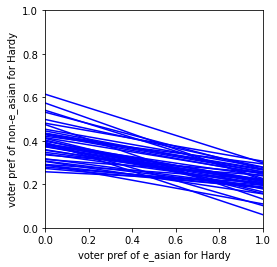

In [3]:
tomography_plot(X,T, demographic_group_name, candidate_name)

## Fitting a modified version of the model from King 1999

This model uses different priors than from King '99: Pareto and uniform hyperparameters are used to perform partial pooling over beta distributions for the groups. The likelihood is the same (binomial) distribution. See, for example [Hierarchical Partial Pooling for Repeated Binary Trials](https://mc-stan.org/rstanarm/articles/pooling.html) for details of this prior structure.

In [9]:
ei= TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=8, pareto_shape=2)
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names)
print(ei_old.summary())

Compiling...


/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compilation time =  0:00:05.811690
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time =  0:00:20.590235
Transforming variables...
Transformation time =  0:00:00.103366
Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.815
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.243
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.60689091 0.96293463]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.21817747 0.27793933]
        


In [6]:
# saving fitted ei model to disk
#to_netcdf(ei,'test_fn')

In [7]:
# loading fitted ei model from disk
#ei = from_netcdf('test_fn')

In [10]:
ei.sim_trace.posterior.attrs

{'created_at': '2022-07-02T17:27:38.939754', 'arviz_version': '0.12.0'}

We can also pass to the fit() function additional keyword arguments for the sampler, such as:

- draws - the number of samples to draw
- chains - the number of chains
- tune - number of iteration to tune
- cores - number of chains to run in parallel

(see https://docs.pymc.io/api/inference.html sampling.sample for more)
E.g.:

In [11]:
ei = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=8, pareto_shape=2)
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names, draws=1200, tune=3000, target_accept=.99)
print(ei.summary())

Compiling...


/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compilation time =  0:00:05.790759
Sampling...


  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

Sampling time =  0:00:28.134533
Transforming variables...
Transformation time =  0:00:00.615762
Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.804
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.245
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.61022726 0.95259481]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.21959122 0.27815048]
        


### Plotting features for this and any model involving posterior samples:

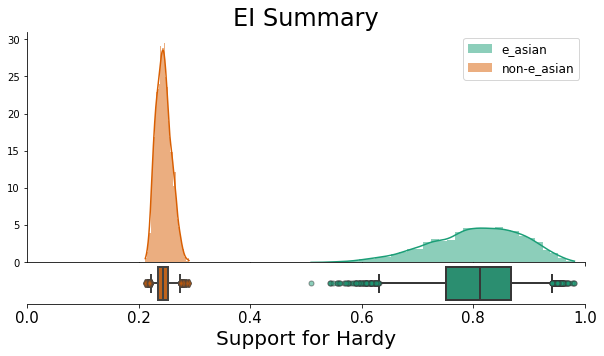

In [25]:
ax = ei.plot()

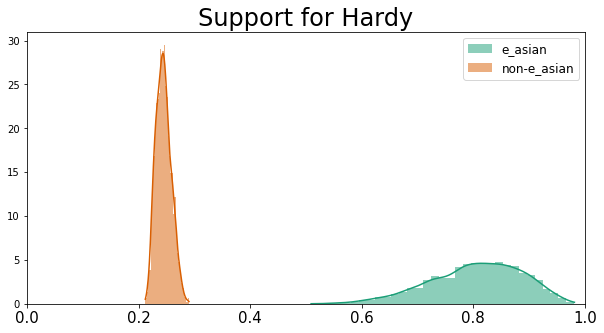

In [26]:
ax = ei.plot_kde()

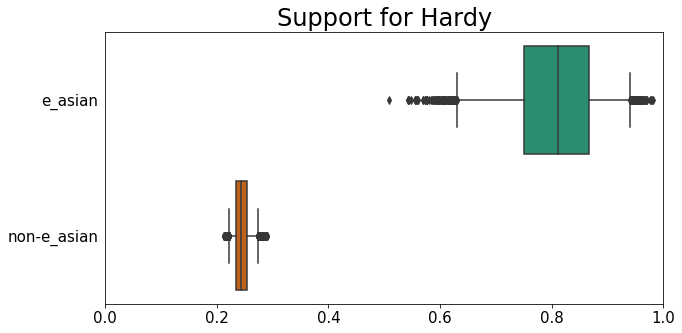

In [27]:
ax = ei.plot_boxplot()

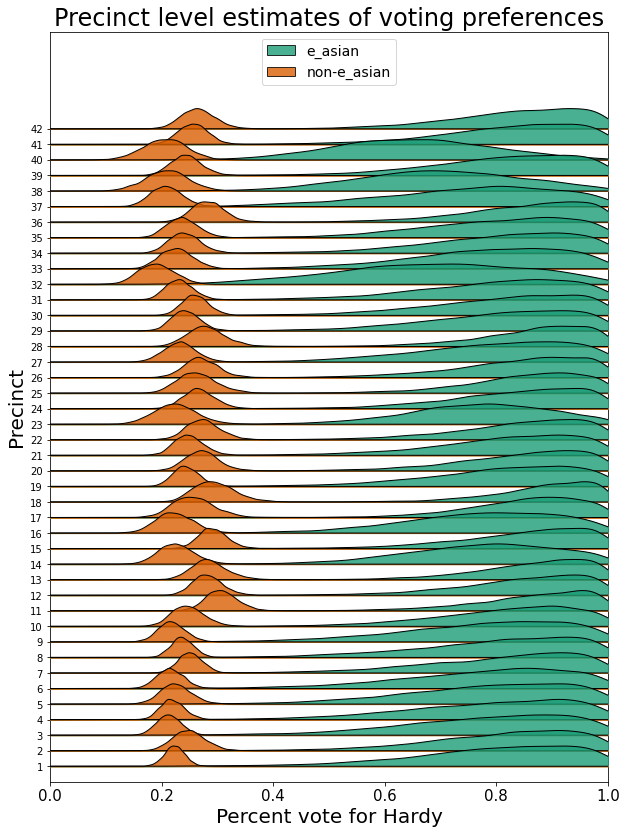

In [28]:
ax = ei.precinct_level_plot(alpha=0.8)

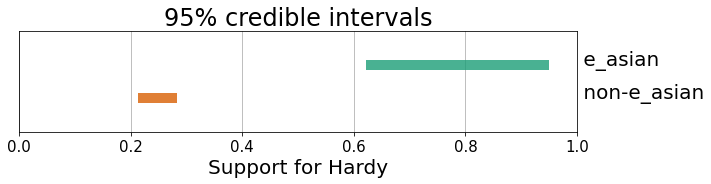

In [29]:
ax = ei.plot_intervals()

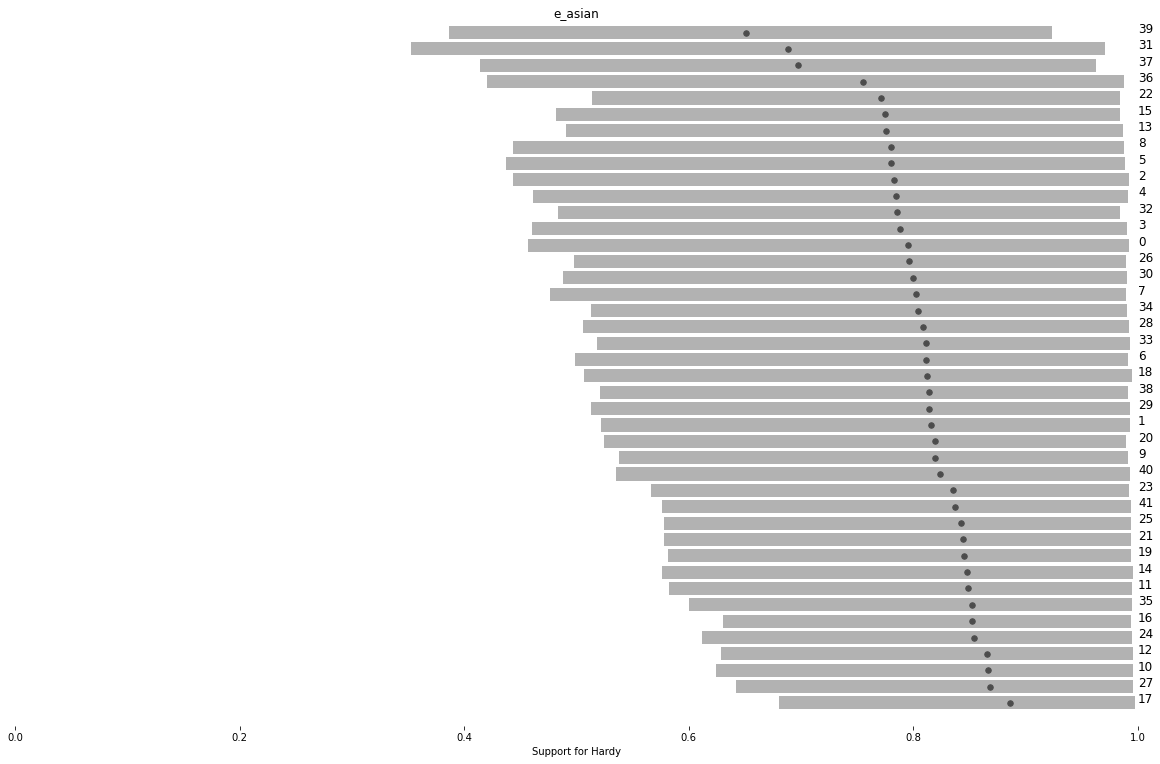

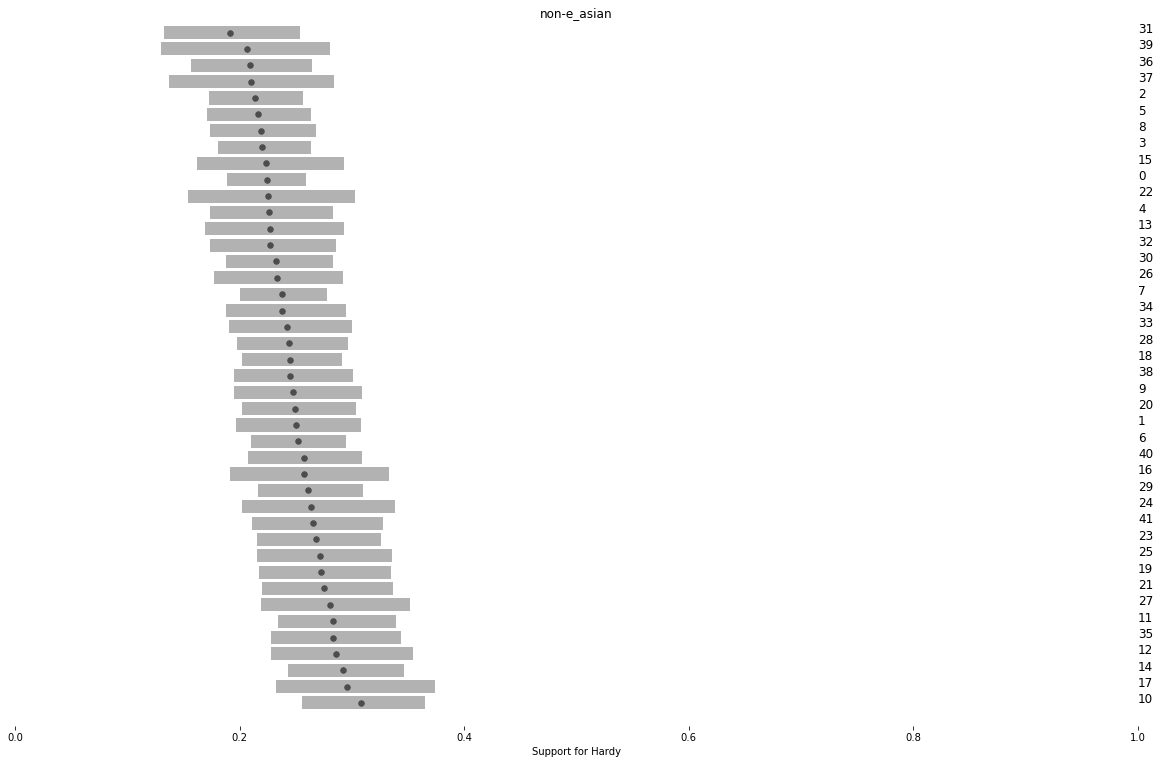

In [30]:
e_asian_ax, non_e_asian_ax = ei.plot_intervals_by_precinct()

### Examine polarization / differences between groups' voting preferences

### a) probability that the difference is above a certain threshold

In [31]:
ei.polarization_report(threshold=0.4)

There is a 94.3% probability that the difference between the groups' preferences for Hardy (e_asian -  non-e_asian) is more than 0.40.


94.275

In [32]:
ei.polarization_report(threshold=-0.4, reference_group=1)

There is a 5.7% probability that the difference between the groups' preferences for Hardy (non-e_asian -  e_asian) is more than -0.40.


5.725

In [33]:
ei.polarization_report(threshold=0.4, verbose=False)

94.275

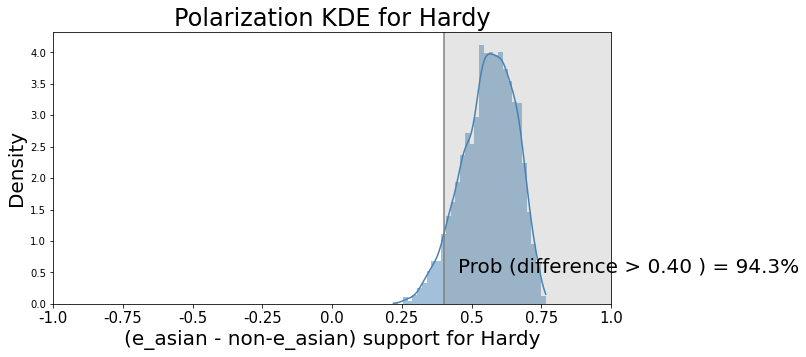

In [34]:
ax = ei.plot_polarization_kde(threshold=0.4, show_threshold=True) #set show_threshold to false to just view the kde

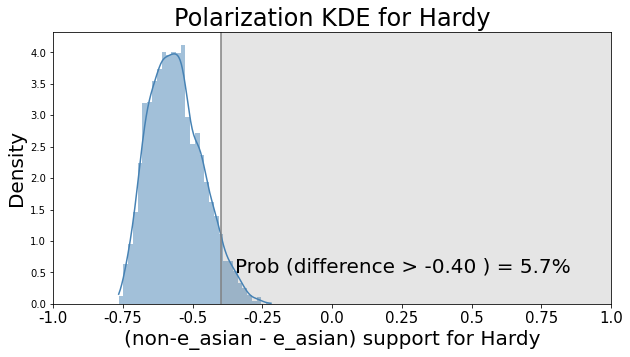

In [35]:
ax = ei.plot_polarization_kde(threshold=-0.4, show_threshold=True, reference_group=1)

### b) find threshold for a desired probability level

In [36]:
ei.polarization_report(percentile=95, verbose=True)

There is a 95% probability that the difference between the groups' preferences for Hardy (e_asian - non-e_asian) is between [0.36, 0.72].


(0.3575597013085353, 0.7188970654243503)

In [37]:
ei.polarization_report(percentile=95, verbose=True, reference_group=1)

There is a 95% probability that the difference between the groups' preferences for Hardy (non-e_asian - e_asian) is between [-0.72, -0.36].


(-0.7188970654243503, -0.3575597013085352)

In [38]:
ei.polarization_report(percentile=95, verbose=False)

(0.3575597013085353, 0.7188970654243503)

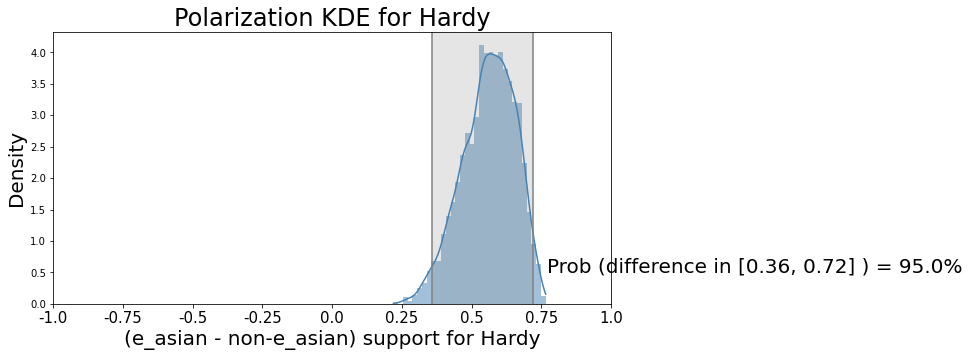

In [39]:
ax = ei.plot_polarization_kde(percentile=95, show_threshold=True)

## Summary features

In [40]:
print(ei.summary())

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.805
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.245
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.63026328 0.94070584]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.22188746 0.2736782 ]
        


### Posterior mean for district-wide voting preferences (mean of [precinct samples weighted by population]):

In [41]:
posterior_mean_voting_prefs =ei.posterior_mean_voting_prefs
print(demographic_group_name, " support for ", candidate_name, posterior_mean_voting_prefs[0])
print("non-",demographic_group_name, " support for ", candidate_name, posterior_mean_voting_prefs[1])


e_asian  support for  Hardy 0.805396404400265
non- e_asian  support for  Hardy 0.24484297350294743


### 95% equal-tailed credible intervals

In [30]:
credible_interval_95_mean_voting_prefs = ei.credible_interval_95_mean_voting_prefs
print(demographic_group_name, " support for ", candidate_name, credible_interval_95_mean_voting_prefs[0])
print("non-",demographic_group_name, " support for ", candidate_name, credible_interval_95_mean_voting_prefs[1])


e_asian  support for  Hardy [0.65558799 0.95118277]
non- e_asian  support for  Hardy [0.21920541 0.26955728]


### Precinct-level posterior means and credible intervals

In [31]:
precinct_posterior_means, precinct_credible_intervals = ei.precinct_level_estimates()
#precinct_posterior_means has shape num_precincts x 2 (groups) x 2 (candidates)
print(precinct_posterior_means[5][0][0]) # Estimated (posterior mean) support for the candidate from the group in precinct 5
#precinct_credible_intervals has shape num_precincts x 2 (groups) x 2 (candidates) x 2 (endpoints))
print(precinct_credible_intervals[5][0][0]) # 95% credible interval of support for the candidate from the group in precint 5

0.7949681507572093
[0.45768158 0.99450629]


## Accessing samples

Samples from the posterior distribution of district-wide voter preferences (calculated by weighting each set of precinct-level samples by the population and summing):

In [32]:
sampled_voting_prefs = ei.sampled_voting_prefs # ei.sampled_voting_prefs is samples of district-level voter preference: list of length 2
sampled_voting_prefs[0] #samples of district-wide support of specified group for specified candidate
sampled_voting_prefs[1] #samples of district-wide support of (complement of specified group) for specified candidate
sampled_voting_prefs[0].mean() #posterior mean
sampled_voting_prefs[1].mean() #posterior mean

0.24250233004093538

Precinct level samples of voting preferences:

In [33]:
precinct_num_of_interest = 5
ei.sim_trace["posterior"]["b_1"].shape # num_chains num_samples x num_precincts

print("calculate posterior mean for voter preference of ", demographic_group_name, " for ", candidate_name," in precinct ",precinct_num_of_interest )

# can extract and combine all chains e.g with sim_trace["posterior"]["b_1"].stack(all_draws=["chain", "draw"]).values.T
b_1_samples_all = ei.sim_trace["posterior"]["b_1"].stack(all_draws=["chain", "draw"]).values.T # num_samples_in_all_chains_total x num_precincts
b_1_samples_all[:, precinct_num_of_interest].mean() 

calculate posterior mean for voter preference of  e_asian  for  Hardy  in precinct  5


0.7949681507572092

Posterior samples for hyperparameters are also accessible.

In [34]:
ei.sim_trace["posterior"]["kappa_1"].shape # num_chains x num_samples

# Note: can combine into one chain and convert to an numpy array like:
ei.sim_trace["posterior"]["kappa_1"].stack(all_draws=["chain", "draw"]).values.T

array([22.7880315 , 23.21211308, 16.9147543 , ..., 10.5226785 ,
        9.10609649, 10.57139149])

## Accessing and visualizing the pymc the model

In [35]:
model = ei.sim_model
pm.model_to_graphviz(model)

TypeError: No model on context stack.

## Fitting the model from King 1999

This is a faithful representation of the model from King '99: all of the hyperparameters are exponentially distributed with a fixed lambda value. 

In [36]:
ei = TwoByTwoEI(
    "king99", lmbda=0.1
)  # king uses 0.5, but smaller lambdas seem more stable
ei.fit(X, T, N, demographic_group_name="e asian", candidate_name="Hardy")
print(ei.summary())

Compiling...


/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


KeyboardInterrupt: 

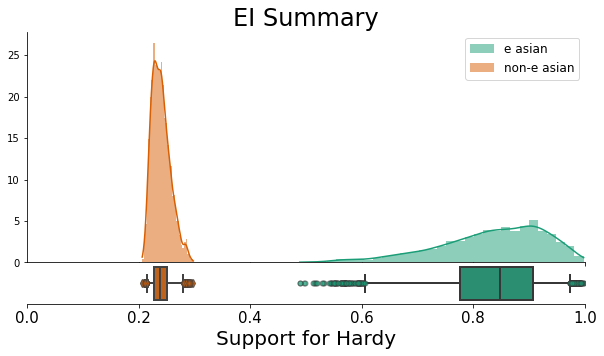

In [35]:
ei.plot();

<AxesSubplot:title={'center':'Precinct level estimates of voting preferences'}, xlabel='Percent vote for Hardy', ylabel='Precinct'>

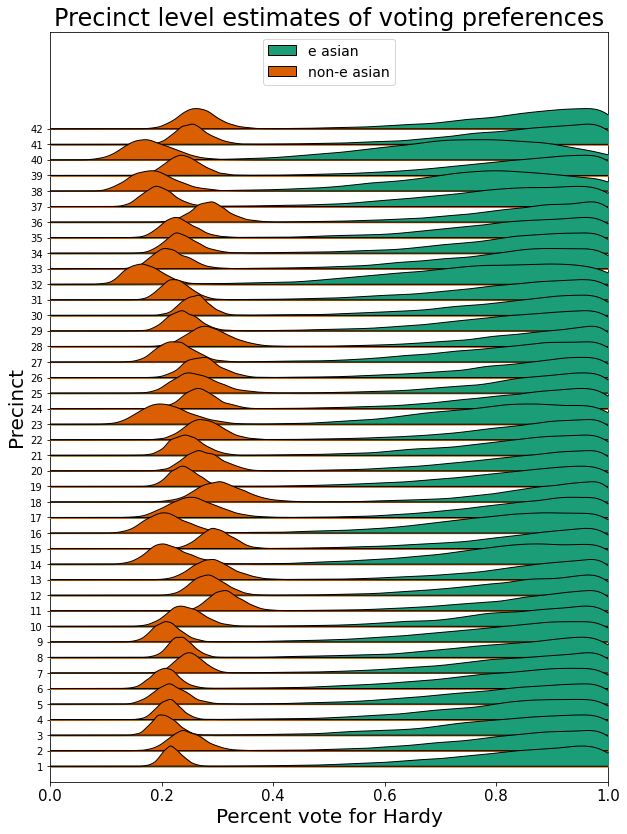

In [36]:
ei.precinct_level_plot()

## Fitting Goodman's ecological regression

In [ ]:
goodmans_er = GoodmansER().fit(
    X, T, demographic_group_name="e asian", candidate_name="Hardy"
)
print(goodmans_er.summary())

In [ ]:
goodmans_er.plot();

## Fitting a weighted version of Goodman's ecological regression

In [ ]:
goodmans_er = GoodmansER(is_weighted_regression="True")
goodmans_er.fit(X, T, N, demographic_group_name="e asian", candidate_name="Hardy")
print(goodmans_er.summary())

In [ ]:
goodmans_er.plot();

## Fitting a Bayesian version of Goodman's ecological regression

With uniform \[0,1\] priors over the voting preferences for each group. Options to weigh the precints based on population or not.

In [ ]:
bayes_goodman_ei = GoodmansERBayes("goodman_er_bayes", weighted_by_pop=True, sigma=1)
bayes_goodman_ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name)
print(bayes_goodman_ei.summary())

In [ ]:
bayes_goodman_ei.plot_kde()

In [ ]:
 x_vals, means, lower_bounds, upper_bounds = bayes_goodman_ei.compute_credible_int_for_line()

In [ ]:
import arviz as az
idata = az.from_pymc3(bayes_goodman_ei.sim_trace, model=bayes_goodman_ei.sim_model)

In [ ]:
idata

In [ ]:
idata.sample_stats.diverging

In [ ]:
az.stats.rhat(idata)